### Task 1

#### 1. Basic Concepts
1. The purpose of using dataset distillation in this paper is to reduce the training costs while maintaining the high performance on various machine learning tasks. The authors introduce Dataset Distillation with Attention Maching (DataDAM) to condense large datasets into smaller synthetic dataset that retain the critical information, allowing models trained on the synthetic set to achieve similar accuracy as those trained on the full dataset.
2.  The advantages are: (page 2)
- Efficient end-to-end dataset distillation: This highlights the ability of DataDAM to closely approximate the distribution of the real dataset while keeping **computational costs low**.
- Improved accuracy and scalability: DataDAM demonstrate the performance across multiple benchmark dataset and reduces the training costs by up to 100x, while also allowing for cross-architecture generation. This makes it more scalable and flexible for real-world application.
- Enhancement of downstream application: DATADAM's distilled data improves memory efficiency in continual learning tasks and accelerates neural architectures search(NAS) by providing a more representative proxy dataset, enabling a faster and more efficient learning process.  
3. The novelty includes: (page 2)
- Multiple Randomly Initialized DNNs: DataDAM uses multiple randomly initialized deep neural networks to extract meaningful representations from both real and synthetic datasets, which is different from methods that rely on pre-trained models
- Spatial attention matching (SAM): The SAM module align the most discriminative feature maps from real and synthetic datasets, reducing the gap between the dataset.
- Last-Layer Feature Alignment: It reduces disparities in the last-layer feature distributions between the real and synthetic datasets by using a complementary loss as a regularizer, ensuring high-level abstract representations are similar.
- Bias-Free Synthetic Data: The synthetic data generated by DataDAM does not introduce any bias, which is a significant improvement over prior methods, ensuring better generalization and performance.
4. The methodology of DataDAM is centered on efficiently distilling datasets through attention matching: (page 4)
- Initialization of Synthetic Dataset: The process starts by initializing a synthetic dataset, which can be done through random noise or by sampling real data.
- Feature Extraction: Real and synthetic datasets are passed through randomly initialized deep neural networks, and features are extracted at multiple layers.
- Spatial Attention Matching (SAM): Attention maps are computed for each layer, excluding the final layer. These attention maps focus on the most discriminative regions of the input image. 
- Loss Functions:
    - SAM Loss (LSAM): This loss minimizes the distance between attention maps of real and synthetic datasets across layers.
    - Maximum Mean Discrepancy Loss (MMD): This complementary loss aligns the last-layer feature distributions of the two datasets, ensuring the high-level abstract information is captured.
- Optimization: The synthetic dataset is optimized using a combination of the SAM loss and LMMD loss to minimize the difference between real and synthetic data.
5. (page 8)
- Continual Learning: DataDAM’s ability to condense datasets efficiently makes it highly useful in continual learning scenarios, where a model must learn incrementally while preventing catastrophic forgetting. By using the distilled datasets as a replay buffer, DataDAM can significantly improve memory efficiency and performance in incremental learning tasks.
- Neural Architecture Search (NAS): The synthetic datasets generated by DataDAM can serve as proxies in NAS tasks, allowing faster evaluation of model architectures. This leads to a significant reduction in computational costs and time during the model search process, making NAS more feasible in real-world applications.

#### 2. Data Distillation Learning - MHIST

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import CosineAnnealingLR

In [2]:
import import_ipynb
from utils import get_network, get_time

In [23]:
train_folder = 'mhist_dataset/train'
test_folder = 'mhist_dataset/test'

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


In [86]:
model = get_network(model='ConvNetD7', channel=3, num_classes=2, im_size=(224, 224)) 
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, T_max=20)
criterion = torch.nn.CrossEntropyLoss()

In [87]:
for epoch in range(20):
    model.train()
    
    running_loss = 0.0
    for inputs, labels in train_loader:
        labels = labels.long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    scheduler.step()
    
    print(f"Epoch [{epoch+1}/20], Loss: {running_loss / len(train_loader.dataset)}")

Epoch [1/20], Loss: 0.5947140841100408
Epoch [2/20], Loss: 0.5157252245798878
Epoch [3/20], Loss: 0.45017109185799786
Epoch [4/20], Loss: 0.4037635742521834
Epoch [5/20], Loss: 0.3641434731702695
Epoch [6/20], Loss: 0.3095263673039688
Epoch [7/20], Loss: 0.24945628910229123
Epoch [8/20], Loss: 0.20727865527416098
Epoch [9/20], Loss: 0.15143943229625964
Epoch [10/20], Loss: 0.1190210526085448
Epoch [11/20], Loss: 0.06751158037576183
Epoch [12/20], Loss: 0.03612222052853683
Epoch [13/20], Loss: 0.01850891020791284
Epoch [14/20], Loss: 0.012948476869998306
Epoch [15/20], Loss: 0.009529292491403805
Epoch [16/20], Loss: 0.008175495855253317
Epoch [17/20], Loss: 0.007496611589416005
Epoch [18/20], Loss: 0.007121032947438887
Epoch [19/20], Loss: 0.006932447967173039
Epoch [20/20], Loss: 0.006843742505358211


In [88]:
model_path = 'models/mhist_original.pth'
torch.save(model.state_dict(), model_path)

In [5]:
model_path = 'models/mhist_original.pth'
model = get_network(model='ConvNetD7', channel=3, num_classes=2, im_size=(224, 224)) 
model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [90]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        labels = labels.long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 79.84%


In [91]:
from ptflops import get_model_complexity_info

macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
print(f"MACs: {macs}, Parameters: {params}")

ConvNet(
  891.14 k, 100.000% Params, 2.68 GMac, 99.365% MACs, 
  (features): Sequential(
    890.88 k, 99.971% Params, 2.68 GMac, 99.365% MACs, 
    (0): Conv2d(3.58 k, 0.402% Params, 179.83 MMac, 6.664% MACs, 3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm(256, 0.029% Params, 12.85 MMac, 0.476% MACs, 128, 128, eps=1e-05, affine=True)
    (2): ReLU(0, 0.000% Params, 6.42 MMac, 0.238% MACs, inplace=True)
    (3): AvgPool2d(0, 0.000% Params, 6.42 MMac, 0.238% MACs, kernel_size=2, stride=2, padding=0)
    (4): Conv2d(147.58 k, 16.561% Params, 1.85 GMac, 68.604% MACs, 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): GroupNorm(256, 0.029% Params, 3.21 MMac, 0.119% MACs, 128, 128, eps=1e-05, affine=True)
    (6): ReLU(0, 0.000% Params, 1.61 MMac, 0.060% MACs, inplace=True)
    (7): AvgPool2d(0, 0.000% Params, 1.61 MMac, 0.060% MACs, kernel_size=2, stride=2, padding=0)
    (8): Conv2d(147.58 k, 16.561% Params, 462.82 MMac, 17.151% MACs, 128,

In [92]:
total_flops = 0

for inputs, labels in test_loader:
    total_flops += get_model_complexity_info(model, (3, 224, 224), as_strings=False)[0]

print(f"Total FLOPs for the test dataset: {total_flops}")

ConvNet(
  891.14 k, 100.000% Params, 2.68 GMac, 99.365% MACs, 
  (features): Sequential(
    890.88 k, 99.971% Params, 2.68 GMac, 99.365% MACs, 
    (0): Conv2d(3.58 k, 0.402% Params, 179.83 MMac, 6.664% MACs, 3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm(256, 0.029% Params, 12.85 MMac, 0.476% MACs, 128, 128, eps=1e-05, affine=True)
    (2): ReLU(0, 0.000% Params, 6.42 MMac, 0.238% MACs, inplace=True)
    (3): AvgPool2d(0, 0.000% Params, 6.42 MMac, 0.238% MACs, kernel_size=2, stride=2, padding=0)
    (4): Conv2d(147.58 k, 16.561% Params, 1.85 GMac, 68.604% MACs, 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): GroupNorm(256, 0.029% Params, 3.21 MMac, 0.119% MACs, 128, 128, eps=1e-05, affine=True)
    (6): ReLU(0, 0.000% Params, 1.61 MMac, 0.060% MACs, inplace=True)
    (7): AvgPool2d(0, 0.000% Params, 1.61 MMac, 0.060% MACs, kernel_size=2, stride=2, padding=0)
    (8): Conv2d(147.58 k, 16.561% Params, 462.82 MMac, 17.151% MACs, 128,

In [5]:
# step 4: real dataset loader 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

real_dataset = datasets.ImageFolder(root='mhist_dataset/train', transform=transform)
real_loader = torch.utils.data.DataLoader(real_dataset, batch_size=128, shuffle=True)


In [40]:
# 2b 
# set up the synthetic dataset 
import random

num_classes = 2 
num_images_per_class = 50 
img_size = (3, 224, 224)

def generate_synthetic_dataset_with_noise(real_dataset, num_classes, images_per_class=50, noise_std=0.8):
    synthetic_images = []
    synthetic_labels = []

    for class_id in range(num_classes):
        # Randomly sample 50 images from each class
        indices = random.sample(
            [i for i, (_, label) in enumerate(real_dataset) if label == class_id],
            images_per_class
        )

        for i in indices:
            img_real = real_dataset[i][0]
            noise = torch.rand(size=img_real.shape)

            noise = noise.to(img_real.device)

            synthetic_image = img_real + noise

            synthetic_image = torch.clamp(synthetic_image, 0, 1)

            synthetic_images.append(synthetic_image)
            synthetic_labels.append(real_dataset[i][1])

    
    img_syn = torch.stack(synthetic_images)
    labels_syn = torch.tensor(synthetic_labels)

    return img_syn, labels_syn

In [41]:
#step 2: optimizer 
img_syn, _ = generate_synthetic_dataset_with_noise(real_dataset, num_classes)

img_syn = torch.nn.Parameter(img_syn)
optimizer_img = optim.SGD([img_syn], lr=0.1)  # lr is eta_s


In [42]:
# step 3: set up model - ConvNET - 7 in this case 
# freeze the model's weights so that only the synthetic dataset is updated 
model_path = 'models/mhist_original.pth'
net = get_network(model='ConvNetD7', channel=3, num_classes=2, im_size=(224, 224)) 
net.load_state_dict(torch.load(model_path))
net.train()

for param in list(net.parameters()):
    param.requires_grad = False

In [43]:
# step 5: hook
# Using hook to extract the activations from the layers (attention maps) to compare the attention maps from real to synthetic
activations = {}

def get_activation(name):
    def hook_func(m, inp, op):
        activations[name] = op.detach()

    return hook_func


''' Defining the Refresh Function to store Activations and reset Collection '''


def refresh_activations(activations):
    model_set_activations = []  # Jagged Tensor Creation
    for i in activations.keys():
        model_set_activations.append(activations[i])
    activations = {}
    return activations, model_set_activations


def delete_hooks(hooks):
    for i in hooks:
        i.remove()
    return


def attach_hooks(net):
    hooks = []
    for name, module in net.named_modules():
        if isinstance(module, nn.ReLU):
            hooks.append(module.register_forward_hook(get_activation(name)))
    return hooks

In [44]:
# step 6: Attention Matching Map
def get_attention(feature_set, param=0, exp=4, norm='l2'):
    if param==0:
        attention_map = torch.sum(torch.abs(feature_set), dim=1)
    
    elif param ==1:
        attention_map =  torch.sum(torch.abs(feature_set)**exp, dim=1)
    
    elif param == 2:
        attention_map =  torch.max(torch.abs(feature_set)**exp, dim=1)
    
    if norm == 'l2': 
        # Dimension: [B x (H*W)] -- Vectorized
        vectorized_attention_map =  attention_map.view(feature_set.size(0), -1)
        normalized_attention_maps = F.normalize(vectorized_attention_map, p=2, dim=1)

    return normalized_attention_maps

In [45]:
# step 7: error function
def error(real, syn, err_type="MSE"):
    if err_type == "MSE":
        err = torch.sum((torch.mean(real, dim=0) - torch.mean(syn, dim=0)) ** 2)
    elif err_type == "MAE":
        err = torch.sum(torch.abs(torch.mean(real, dim=0) - torch.mean(syn, dim=0)))
    elif err_type == "MSE_B":
        err = torch.sum(
            (torch.mean(real.reshape(2, -1).cpu(), dim=1) - torch.mean(syn.reshape(2, -1).cpu(), dim=1)) ** 2)
    else:
        raise ValueError("Invalid error type")
    return err

In [46]:
# step 8: training loop
def train_dataset(img_syn, activations={}):
    num_iterations = 200

    losses = []
    for iteration in range(num_iterations):
        print(f"Iteration {iteration + 1}/{num_iterations}")

        images_syn_all = []
        images_real_all = []
        for c in range(num_classes):
            img_real, _ = next(iter(real_loader))
            img_syn_per_class = img_syn[c * num_images_per_class:(c + 1) * num_images_per_class]

            images_real_all.append(img_real)
            images_syn_all.append(img_syn_per_class)

        images_real_all = torch.cat(images_real_all, dim=0)
        images_syn_all = torch.cat(images_syn_all, dim=0)

        net.train()
        hooks = attach_hooks(net)
        output_real = net(images_real_all)[0]
        activations, original_model_set_activations = refresh_activations(activations)

        output_syn = net(images_syn_all)[0]
        activations, syn_model_set_activations = refresh_activations(activations)
        delete_hooks(hooks)

        length_of_network = len(original_model_set_activations)

        loss = torch.tensor(0.0)
        mid_loss = 0
        out_loss = 0
        loss_avg = 0

        for layer in range(length_of_network - 1):
            real_attention = get_attention(original_model_set_activations[layer], param=1, exp=1, norm='l2')
            syn_attention = get_attention(syn_model_set_activations[layer], param=1, exp=1, norm='l2')

            tl = 100 * error(real_attention, syn_attention, err_type="MSE_B")
            loss += tl
            mid_loss += tl.item()

        output_loss = 100 * 0.01 * error(output_real, output_syn, err_type="MSE_B")
        loss += output_loss
        out_loss += output_loss.item()

        optimizer_img.zero_grad()
        loss.backward()
        optimizer_img.step()
        loss_avg += loss.item()
        torch.cuda.empty_cache()

        loss_avg /= (num_classes)
        out_loss /= (num_classes)
        mid_loss /= (num_classes)
        losses.append((loss_avg, out_loss, mid_loss))
        if iteration % 10 == 0:
            print('%s iter = %05d, loss = %.4f' % (get_time(), iteration, loss_avg))

    print("training completed.")
    return img_syn, losses

In [47]:
def save_results(img_syn, losses, noise_type):
    save_path = f"mhist_result/{noise_type}_synthetic_dataset.pt"

    torch.save(img_syn, save_path)

    print(f"Synthetic dataset saved to {save_path}")

    loss_log_path = f"mhist_result/{noise_type}_training_losses.txt"
    with open(loss_log_path, "w") as f:
        for epoch, loss in enumerate(losses):
            f.write(f"Iteration {epoch}: Loss = {loss}\n")

    print(f"Training losses saved to {loss_log_path}")

In [ ]:
img_syn, losses = train_dataset(img_syn)
save_results(img_syn, losses, 'Random')

Iteration 1/200
[2024-10-23 01:19:31] iter = 00000, loss = 0.7326
Iteration 2/200
Iteration 3/200
Iteration 4/200
Iteration 5/200
Iteration 6/200
Iteration 7/200
Iteration 8/200
Iteration 9/200
Iteration 10/200
Iteration 11/200
[2024-10-23 01:55:34] iter = 00010, loss = 6.6751
Iteration 12/200
Iteration 13/200
Iteration 14/200
Iteration 15/200
Iteration 16/200
Iteration 17/200
Iteration 18/200
Iteration 19/200
Iteration 20/200
Iteration 21/200
[2024-10-23 02:26:35] iter = 00020, loss = 0.7770
Iteration 22/200
Iteration 23/200
Iteration 24/200


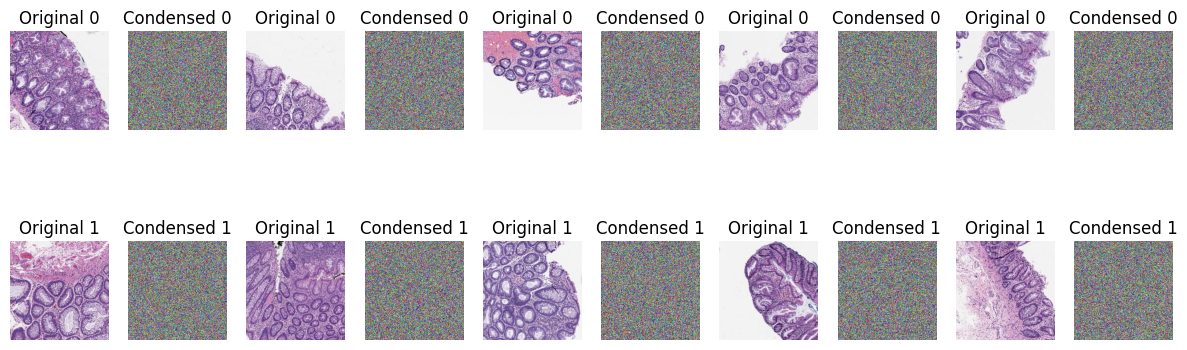

In [6]:
# 2c
import matplotlib.pyplot as plt
import torch

def visualize_comparison(real_loader, img_syn, num_classes, num_images_per_class):
    # Load a batch of real images
    real_images, real_labels = next(iter(real_loader))
    
    # Display fewer images per class to avoid clutter
    num_display = min(5, num_images_per_class)  # Display up to 10 images per class

    fig, axs = plt.subplots(num_classes, num_display * 2, figsize=(15, 5))  # Adjust subplots for fewer images

    for c in range(num_classes):
        for i in range(num_display):
            # Get the real image for class c
            real_img = real_images[i + c * num_display].cpu().detach()
            real_img = real_img.permute(1, 2, 0)  # Change to (H, W, C) for visualization
            real_img = (real_img - real_img.min()) / (real_img.max() - real_img.min())  # Normalize

            # Get the synthetic image for class c
            syn_img = img_syn[c * num_images_per_class + i].cpu().detach()
            syn_img = syn_img.permute(1, 2, 0)  # Change to (H, W, C) for visualization
            syn_img = (syn_img - syn_img.min()) / (syn_img.max() - syn_img.min())  # Normalize
            
            # Plot original (left side)
            axs[c, i * 2].imshow(real_img)
            axs[c, i * 2].set_title(f"Original {c}")
            axs[c, i * 2].axis('off')
            
            # Plot condensed (right side)
            axs[c, i * 2 + 1].imshow(syn_img)
            axs[c, i * 2 + 1].set_title(f"Condensed {c}")
            axs[c, i * 2 + 1].axis('off')

    plt.show()

img_syn_loaded = torch.load('mhist_result/synthetic_dataset.pt')

# Visualize the comparison between original and condensed images (up to 10 images per class)
visualize_comparison(real_loader, img_syn_loaded, num_classes=2, num_images_per_class=50)

In [ ]:
# 2d 
def generate_synthetic_dataset_with_noise(real_dataset, num_classes, images_per_class=50, noise_std=0.8):
    synthetic_images = []
    synthetic_labels = []

    for class_id in range(num_classes):
        # Randomly sample 50 images from each class
        indices = random.sample(
            [i for i, (_, label) in enumerate(real_dataset) if label == class_id],
            images_per_class
        )

        for i in indices:
            img_real = real_dataset[i][0]
            noise = torch.normal(mean=0, std=noise_std, size=img_real.shape)

            noise = noise.to(img_real.device)

            synthetic_image = img_real + noise

            synthetic_image = torch.clamp(synthetic_image, 0, 1)

            synthetic_images.append(synthetic_image)
            synthetic_labels.append(real_dataset[i][1])

    # Stack images to return a tensor for training
    img_syn = torch.stack(synthetic_images)
    labels_syn = torch.tensor(synthetic_labels)

    return img_syn, labels_syn

img_syn, _ = generate_synthetic_dataset_with_noise(real_dataset, num_classes)
img_syn = torch.nn.Parameter(img_syn)
optimizer_img = optim.SGD([img_syn], lr=0.1)  # lr is eta_s

img_syn, losses = train_dataset(img_syn)
save_results(img_syn, losses, 'Gaussian')

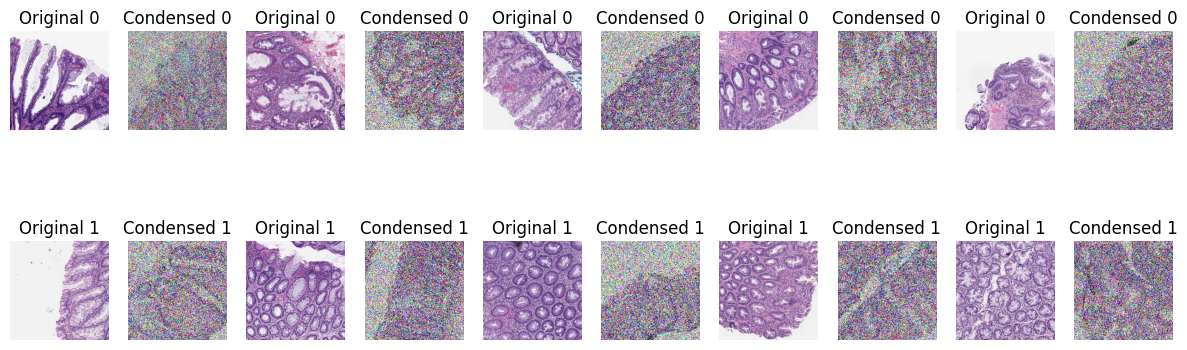

In [7]:
img_syn_loaded = torch.load('mhist_result/Gaussian_synthetic_dataset.pt')
visualize_comparison(real_loader, img_syn_loaded, num_classes=2, num_images_per_class=50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14541455..1.1293434].


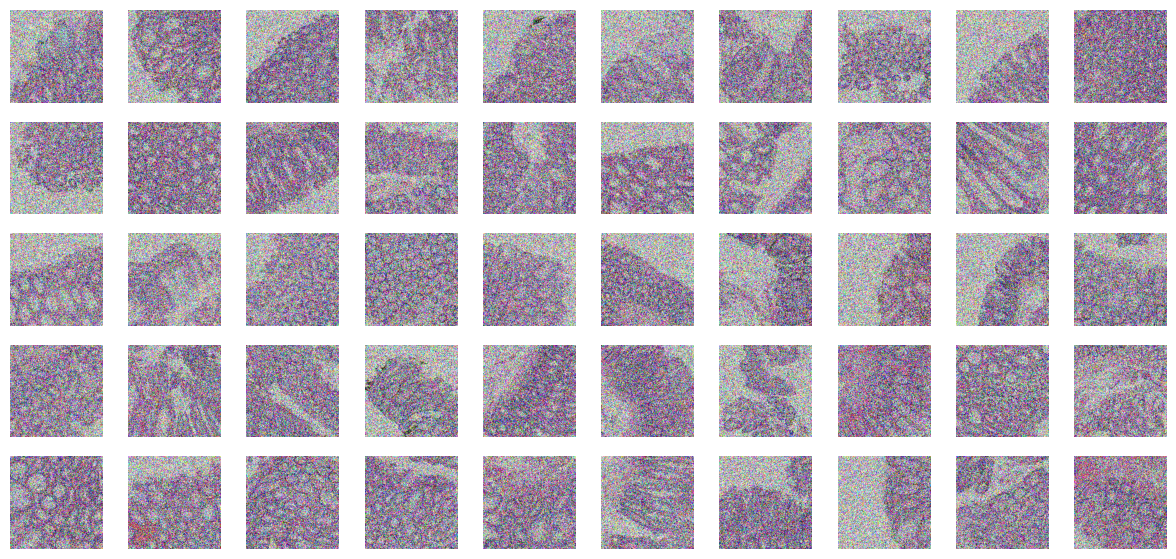

In [11]:
img_array = img_syn_loaded.cpu().detach().numpy()

fig, axes = plt.subplots(5, 10, figsize=(15, 7)) 


axes = axes.flatten()

for i in range(50):
    ax = axes[i]
    img = img_array[i].squeeze()  
    ax.imshow(img.transpose(1, 2, 0)) 
    ax.axis('off')

plt.savefig('mhist_result/output_gaussian.png', bbox_inches='tight')
plt.show() 